In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [29]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 1
WINDOW_WIDTH=32
SHIFT=32
SHUFFLE=True
MAX_EPOCHS = 10000
BATCH_SIZE=256
PATIENCE=250

#alphas = [0.001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 1.999]
#color_set = ['lightcoral', 'red', 'orange', 'yellow', 'green',  'springgreen', 'royalblue', 'blueviolet', 'magenta']
alphas = [0.001, 0.5, 1.0,  1.5, 1.999]
alphas = [0.5, 1.5]
color_set = ['maroon', 'orange', 'green', 'royalblue', 'purple']
NB_LABEL_FEATURES = len(alphas)

In [3]:
N = 2
T = 200
L = None

In [4]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

[ 24  71  83 172 200]
[0.3 0.5 0.3 0.5 0.3]
(80, 2)
(80, 2)


TypeError: '>' not supported between instances of 'float' and 'NoneType'

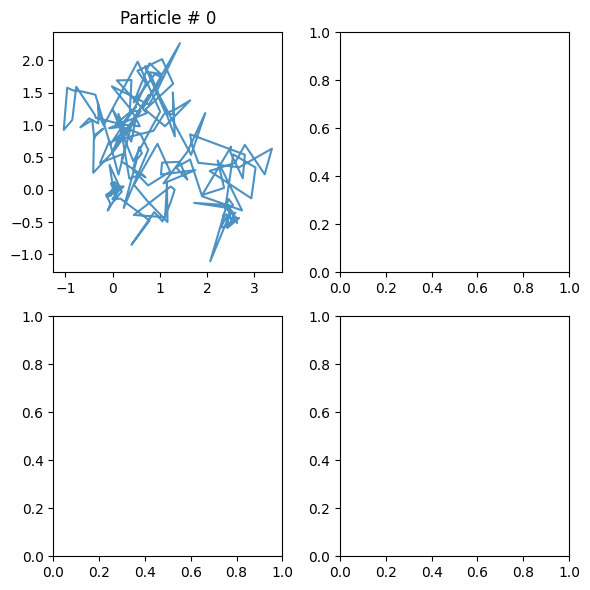

In [113]:
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
left_seqs = []
right_seqs = []
ys_left_seqs = []
ys_right_seqs = []
non_left_seqs = []
non_right_seqs = []
non_left_seqs2 = []
non_right_seqs2 = []
seq_change_points = []
nb = 1
cur_nb = 0
SEARCH_WIDTH = 2
while cur_nb < nb:
    Ts = [WINDOW_WIDTH]
    alphas_copy = alphas.copy()
    T = int(np.random.choice(Ts, 1, replace=False)[0])
    alpha1, alpha2 = np.random.choice(alphas_copy, 2, replace=False)
    trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=200,
                                                            alphas=[0.3, 0.5],  # Fixed alpha for each state
                                                            Ds=[[0.01, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.99, 0.01], [0.01, 0.99]]
                                                           )
    non_trajs_model, non_labels = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=200,
                                                            alphas=[0.5, 0.5],  # Fixed alpha for each state
                                                            Ds=[[0.5, 0.0], [0.5, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )
    non_trajs_model2, non_labels2 = models_phenom().multi_state(N=2,
                                                            L=None,
                                                            T=200,
                                                            alphas=[1.5, 1.5],  # Fixed alpha for each state
                                                            Ds=[[0.5, 0.0], [0.5, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )
    changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
    changepoints1, _, _, _ = label_continuous_to_list(non_labels[:, 0, :])
    changepoints2, _, _, _ = label_continuous_to_list(non_labels2[:, 0, :])

    #if len(changepoints) > 1 and changepoints[0] > SEARCH_WIDTH and changepoints[0] < 200-SEARCH_WIDTH:
    if True:
        for index, seqxy in enumerate([trajs_model[:, 0, 0]]):
            xs = seqxy
            for i in range(SEARCH_WIDTH, WINDOW_WIDTH - SEARCH_WIDTH):
                left_seq = (xs[i - SEARCH_WIDTH:i] / np.std(xs[i - SEARCH_WIDTH:i]))
                right_seq = (xs[i:i + SEARCH_WIDTH] / np.std(xs[i - SEARCH_WIDTH:i]))
                left_seq = np.cumsum(abs(uncumulate(left_seq))) / SEARCH_WIDTH
                right_seq = np.cumsum(abs(uncumulate(right_seq))) / SEARCH_WIDTH
                left_seqs.append(left_seq)
                right_seqs.append(right_seq)

        for index, seqxy in enumerate([trajs_model[:, 0, 1]]):
            ys = seqxy
            for i in range(SEARCH_WIDTH, WINDOW_WIDTH - SEARCH_WIDTH):
                ys_left_seq = (ys[i - SEARCH_WIDTH:i] / np.std(ys[i - SEARCH_WIDTH:i]))
                ys_right_seq = (ys[i:i + SEARCH_WIDTH] / np.std(ys[i - SEARCH_WIDTH:i]))
                ys_left_seq = np.cumsum(abs(uncumulate(ys_left_seq))) / SEARCH_WIDTH
                ys_right_seq = np.cumsum(abs(uncumulate(ys_right_seq))) / SEARCH_WIDTH
                ys_left_seqs.append(ys_left_seq)
                ys_right_seqs.append(ys_right_seq)
        
        for index, seqxy in enumerate([non_trajs_model[:, 0, 0]]):
            xs = seqxy
            for i in range(SEARCH_WIDTH, WINDOW_WIDTH - SEARCH_WIDTH):
                non_left_seq = (xs[i - SEARCH_WIDTH:i] / np.std(xs[i - SEARCH_WIDTH:i]))
                non_right_seq = (xs[i:i + SEARCH_WIDTH] / np.std(xs[i - SEARCH_WIDTH:i]))
                non_left_seq = np.cumsum(abs(uncumulate(non_left_seq))) / SEARCH_WIDTH
                non_right_seq = np.cumsum(abs(uncumulate(non_right_seq))) / SEARCH_WIDTH
                non_left_seqs.append(non_left_seq)
                non_right_seqs.append(non_right_seq)

        for index, seqxy in enumerate([non_trajs_model2[:, 0, 0]]):
            xs = seqxy
            for i in range(SEARCH_WIDTH, WINDOW_WIDTH - SEARCH_WIDTH):
                non_left_seq2 = (xs[i - SEARCH_WIDTH:i] / np.std(xs[i - SEARCH_WIDTH:i]))
                non_right_seq2 = (xs[i:i + SEARCH_WIDTH] / np.std(xs[i - SEARCH_WIDTH:i]))
                non_left_seq2 = np.cumsum(abs(uncumulate(non_left_seq2))) / SEARCH_WIDTH
                non_right_seq2 = np.cumsum(abs(uncumulate(non_right_seq2))) / SEARCH_WIDTH
                non_left_seqs2.append(non_left_seq2)
                non_right_seqs2.append(non_right_seq2)

        seq_change_points.append(changepoints)
        cur_nb += 1
        print(changepoints)
        print(alphas_cp)
                

left_seqs = np.array(left_seqs)
right_seqs = np.array(right_seqs)
ys_left_seqs = np.array(ys_left_seqs)
ys_right_seqs = np.array(ys_right_seqs)
non_left_seqs = np.array(non_left_seqs)
non_right_seqs = np.array(non_right_seqs)
non_left_seqs2 = np.array(non_left_seqs2)
non_right_seqs2 = np.array(non_right_seqs2)
print(left_seqs.shape)
print(right_seqs.shape)

plot_trajs(trajs_model[:, 0:2, :], L, 1, num_to_plot =2)

36: [  0 183 184 185 186 187 188 189 190 191]
48: [  0 177 178 179 180 181 182 183 184 185]
60: [  0 171 172 173 174 175 176 177 178 179]
72: [  0 178 177 176 175 174 173 179 172 170]
84: [  0 175 174 173 172 171 170 169 168 167]
[ 24  71  83 172 200]
[0.3 0.5 0.3 0.5 0.3]
[174 178 175 179 173 176 172 180 177  20  21 181  24 171  23  19  25  26
  22 182  18 170  27 168 169  17 183 167  33  32]


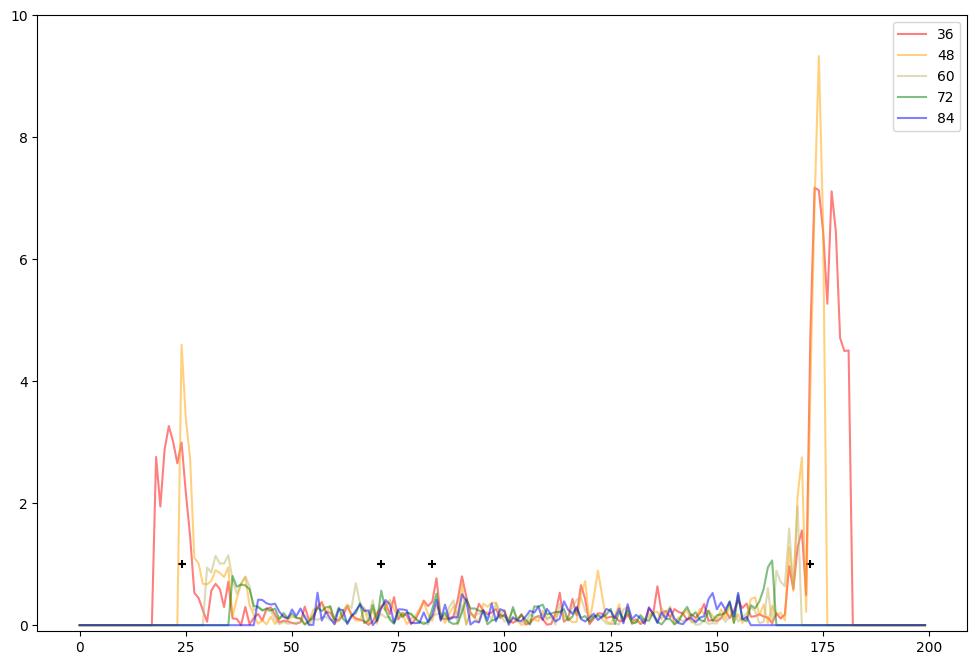

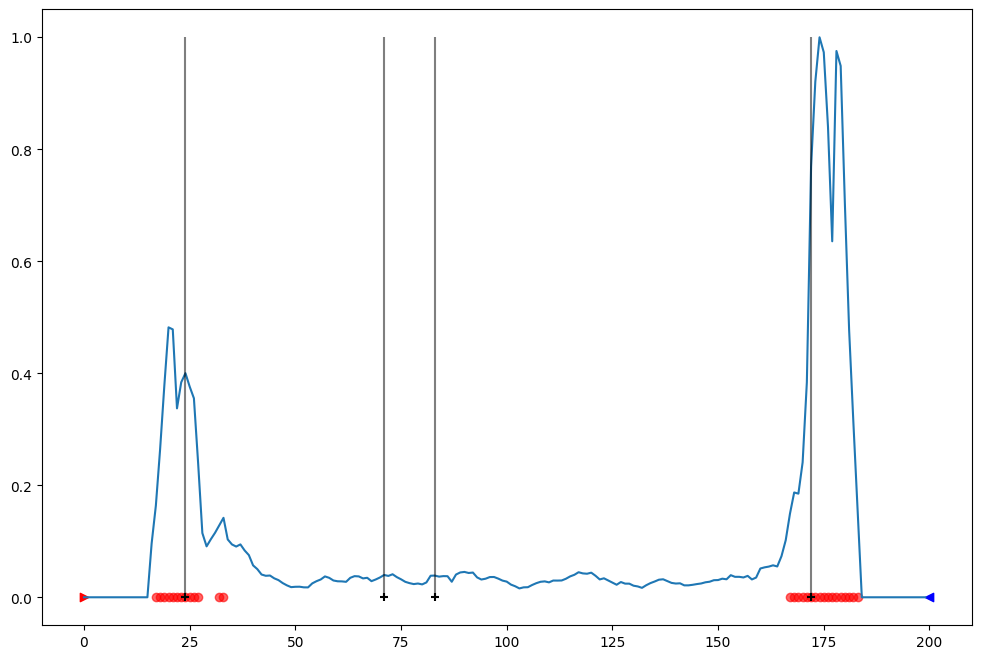

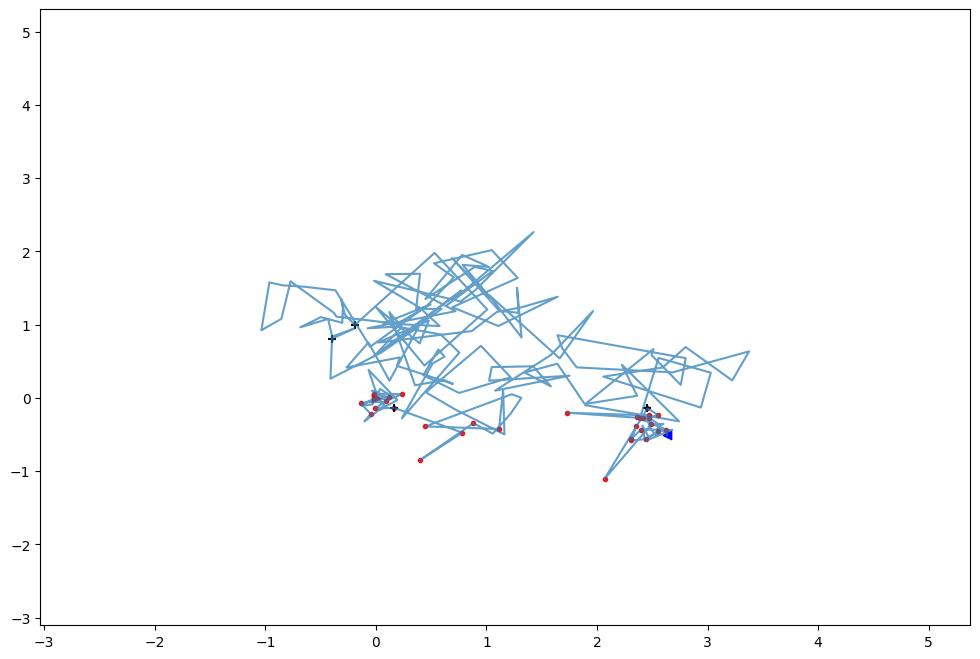

In [118]:
SEARCH_WIDTH = 2
all_vals = []
plt.figure(figsize=(12, 8))
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
COLORS = np.array(['red', 'orange', 'darkkhaki', 'green', 'blue', 'cyan', 'purple'])[:len(WINDOW_WIDTHS)]
for WINDOW_WIDTH, c in zip(WINDOW_WIDTHS, COLORS):
    vals = []
    for checkpoint in range(int(WINDOW_WIDTH/2), 200 - int(WINDOW_WIDTH/2)):
        xs = trajs_model[:, 0, 0][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        ys = trajs_model[:, 0, 1][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

        xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
        xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

        ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
        ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

        std_xs1 = np.std(xs1)
        std_xs2 = np.std(xs2)
        std_ys1 = np.std(ys1)
        std_ys2 = np.std(ys2)


        surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
        surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
        surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
        surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH
        
    
        xs1 = np.cumsum(abs(xs1)) #* surface_xs1
        xs2 = np.cumsum(abs(xs2)) #* surface_xs2
        ys1 = np.cumsum(abs(ys1)) #* surface_ys1
        ys2 = np.cumsum(abs(ys2)) #* surface_ys2


        xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
        xs1 = xs1 / xs_max_val
        xs2 = xs2 / xs_max_val
        xs1 = xs1 / WINDOW_WIDTH
        xs2 = xs2 / WINDOW_WIDTH

        ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
        ys1 = ys1 / ys_max_val
        ys2 = ys2 / ys_max_val
        ys1 = ys1 / WINDOW_WIDTH 
        ys2 = ys2 / WINDOW_WIDTH
 

        """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
        """
    
        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #vals.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #vals.append(abs(np.sum(xs1 - xs2)) * abs(np.sum(ys1 - ys2))) 
        #vals.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #vals.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1]))) 
        #vals.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #vals.append(abs(np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
        #           + abs(np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))
        #vals.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #           + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))
        #vals.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) * np.sqrt((std_xs1 - std_xs2)**2 + (std_ys1 - std_ys2)**2))
        #vals.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) * abs((std_xs1 / std_xs2) * (std_ys1 / std_ys2)))          
        vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                   * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                         * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))
        
        
        """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
        x_kl = scipy.special.kl_div(xs1, xs2, out=None)
        y_kl = scipy.special.kl_div(ys1, ys2, out=None)
        """

        #vals.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)
        
        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)
        vals.append(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
             + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
        """
        
    vals = np.concatenate((np.zeros(int(WINDOW_WIDTH/2)), vals))
    vals = np.concatenate((vals, np.zeros(int(WINDOW_WIDTH/2))))
    
    vals = np.array(vals)
    #vals = vals / np.max(vals)
    all_vals.append(vals)
    
    #plt.figure(figsize=(12, 8))
    #plt.plot(np.arange(int(WINDOW_WIDTH/2), 200 - int(WINDOW_WIDTH/2)), vals[:, 0])
    #plt.plot(np.arange(int(WINDOW_WIDTH/2), 200 - int(WINDOW_WIDTH/2)), vals[:, 1])
    
    plt.plot(np.arange(200), vals, label=f'{WINDOW_WIDTH}', c=c, alpha=0.5)
    args = np.argsort(vals)[:10]
    print(f'{WINDOW_WIDTH}: {args}')
    #plt.scatter(args, np.zeros(len(args)), c=c, alpha=0.5)
plt.ylim([-0.1, max(10, np.max(all_vals))])
#plt.xlim([150, 175])



new_all_vals = []
for i in range(len(all_vals)):
    tmp = []
    for j in range(len(all_vals[i])):
        if j < SEARCH_WIDTH:
            tmp.append(all_vals[i][j] * ((SEARCH_WIDTH * 2) + 1))
        elif j > len(all_vals[i]) - 1 - SEARCH_WIDTH:
            tmp.append(all_vals[i][j] * ((SEARCH_WIDTH * 2) + 1))
        else:
            tmp.append(np.sum(all_vals[i][j-SEARCH_WIDTH:j+SEARCH_WIDTH+1]))
    tmp = np.array(tmp)
    new_all_vals.append(tmp)
new_all_vals = np.array(new_all_vals)
multiplicated_mat = np.ones(new_all_vals[0].shape)
for i in range(len(new_all_vals)):
    multiplicated_mat *= new_all_vals[i]
#new_all_vals = multiplicated_mat
#new_all_vals = np.mean(new_all_vals, axis=0)
all_vals = np.array(new_all_vals)

tmp = []
for j in range(len(all_vals[0])):
    tmp_sum = 0
    count = 0
    for i in range(len(all_vals)):
        if all_vals[i][j] != 0:
            tmp_sum += all_vals[i][j]
            count += 1
    if count == 0:
        tmp.append(0)
    else:
        tmp.append(tmp_sum / count)
all_vals = np.array(tmp)
#all_vals = np.log(all_vals)
all_vals = all_vals / np.max(all_vals)

plt.scatter(changepoints[:-1], np.zeros(len(changepoints)-1) + 1, c='black',  marker='+')
plt.legend()
plt.savefig('sep_vals')

plt.figure(figsize=(12, 8))
args = np.argsort(all_vals)[::-1][:30]
plt.plot(np.arange(200), all_vals) 
plt.scatter(args, np.ones(len(args)) * np.min(all_vals), c='red', alpha=0.6)
plt.scatter(changepoints[:-1], np.ones(len(changepoints)-1) * np.min(all_vals), c='black',  marker='+')
plt.vlines([changepoints[:-1]], ymin=np.min(all_vals), ymax=np.max(all_vals), colors='black', alpha=0.5)
plt.scatter(0, 0, marker='>', c='red')
plt.scatter(200, 0, marker='<', c='blue')
#plt.ylim([-0.1, max(10, np.max(all_vals))])
plt.savefig('all_vals')

plt.figure(figsize=(12, 8))
plt.plot(trajs_model[:, 0, 0], trajs_model[:, 0, 1], alpha=0.7)
plt.scatter(trajs_model[:, 0, 0][args], trajs_model[:, 0, 1][args], c='red', alpha=0.9, s=9)
plt.scatter(trajs_model[:, 0, 0][changepoints[:-1]], trajs_model[:, 0, 1][changepoints[:-1]], c='black', marker='+')
plt.xlim([np.min(trajs_model[:, 0, 0]) - 2,
          np.min(trajs_model[:, 0, 0]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
            np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1])) + 2])
plt.ylim([np.min(trajs_model[:, 0, 1]) - 2,
          np.min(trajs_model[:, 0, 1]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
            np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1])) + 2])
plt.scatter(trajs_model[:, 0, 0][0], trajs_model[:, 0, 1][0], marker='>', c='red')
plt.scatter(trajs_model[:, 0, 0][-1], trajs_model[:, 0, 1][-1], marker='<', c='blue')
plt.savefig('trajectory')
print(changepoints)
print(alphas_cp)
print(args)

0.0447891201223017 -0.13185588967727385
0.6315067287236086 0.6111008593726507 0.35086735711048234 0.6054475727953083
-0.09710910704120562 0.04562486179839207
0.644769827653871 0.6657587598160983 0.7895157613992574 0.538465905960452
0.04143802901882162 0.0666268646420921
0.7929365905553787 0.6156787291888626 1.1013536178221166 0.9179874555388747
0.02997131300666472 -0.05373313539459963
0.9045615888407732 0.5893587593848729 1.2036338147462207 1.1149400561861684
-0.06467798087197055 -0.08300759650630693
0.8688349078944916 0.5882241511800355 1.1908462784680447 1.2348444761406552
[0.15525696630716834, 0.07794515548576456, 0.1669778928154712, 0.03937141344896177, 0.22619815313447172]
-6.204317375715775


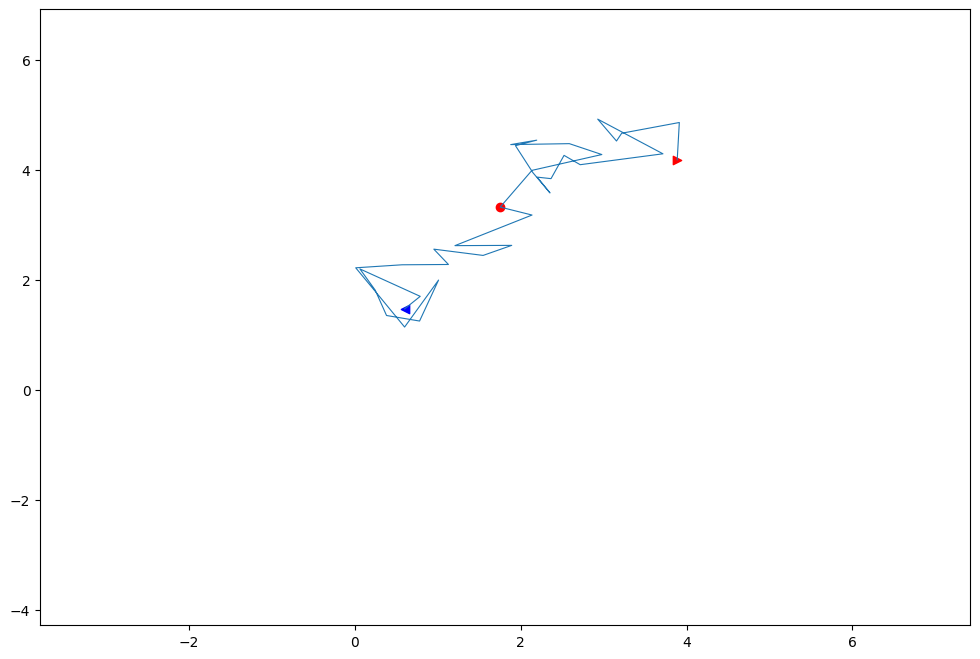

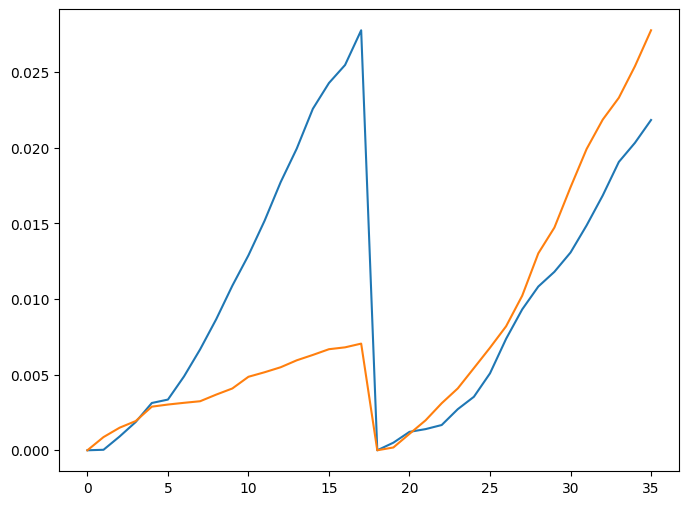

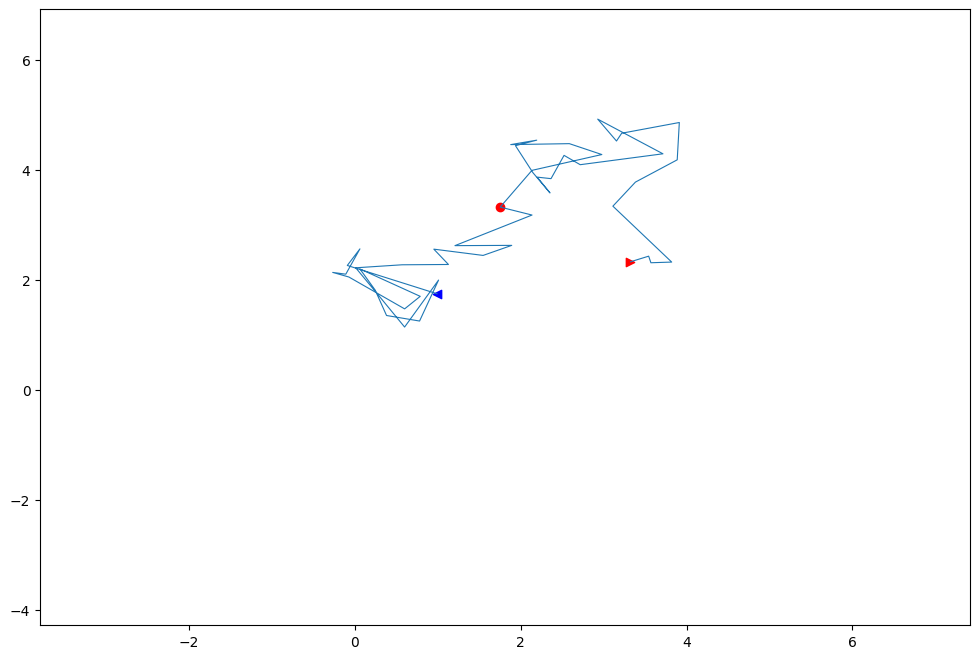

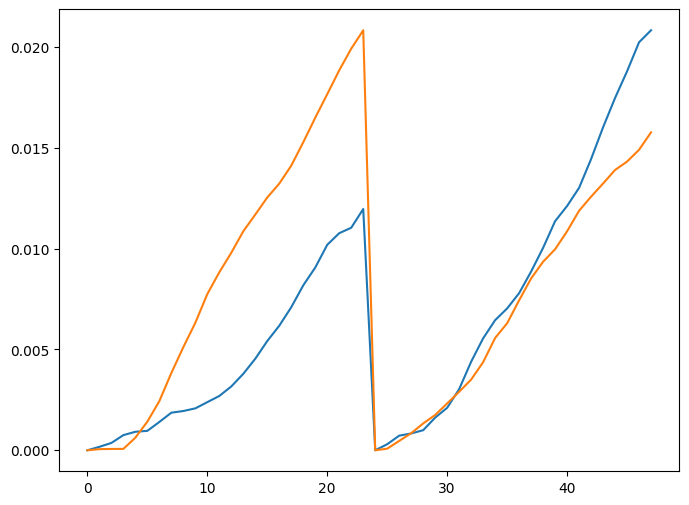

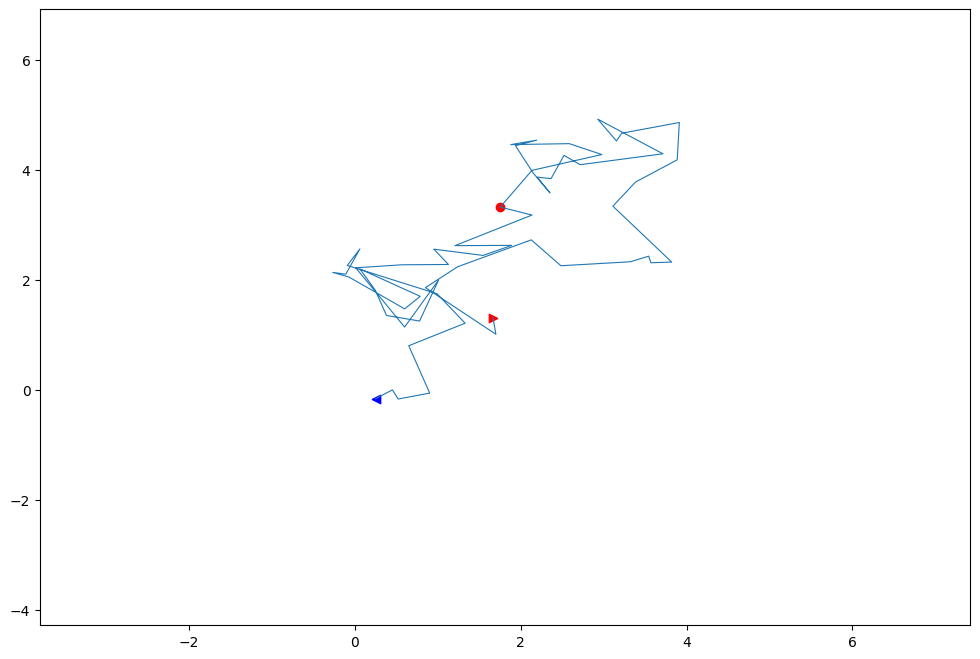

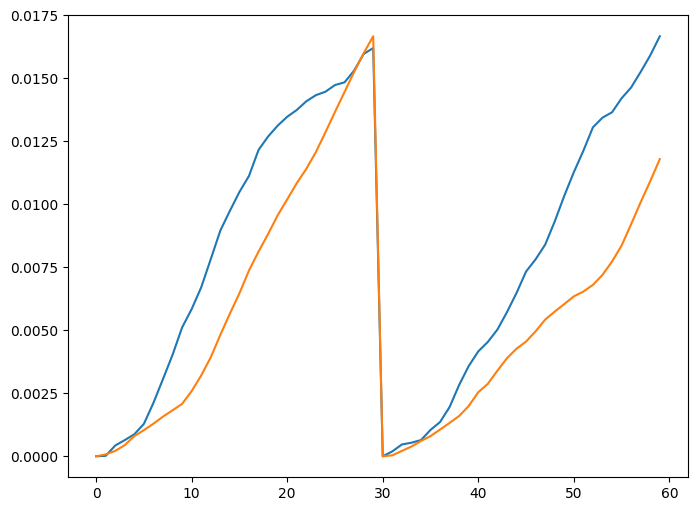

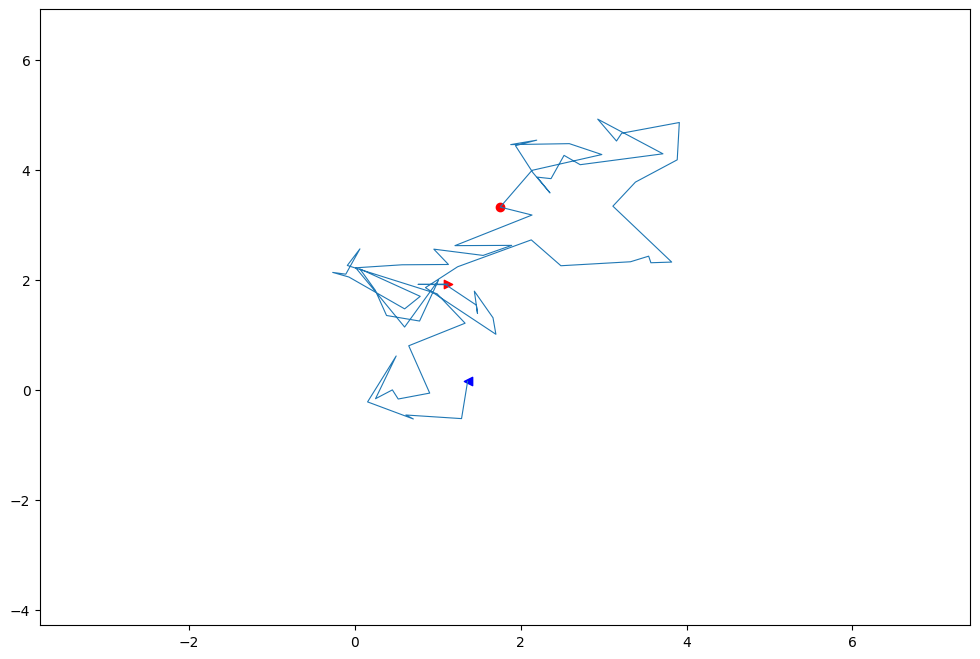

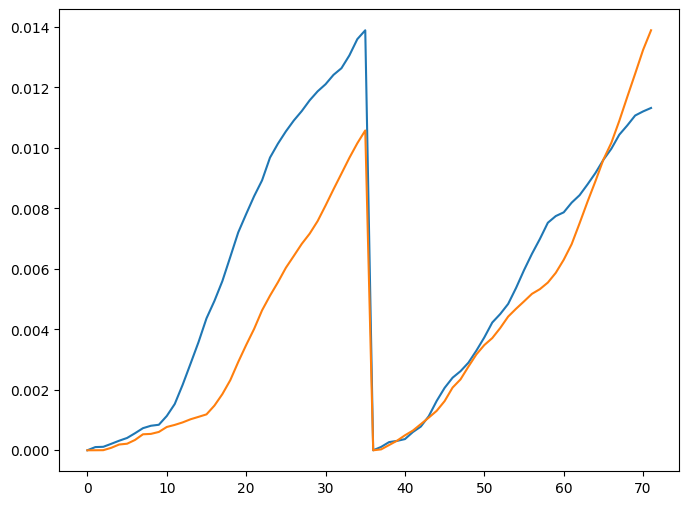

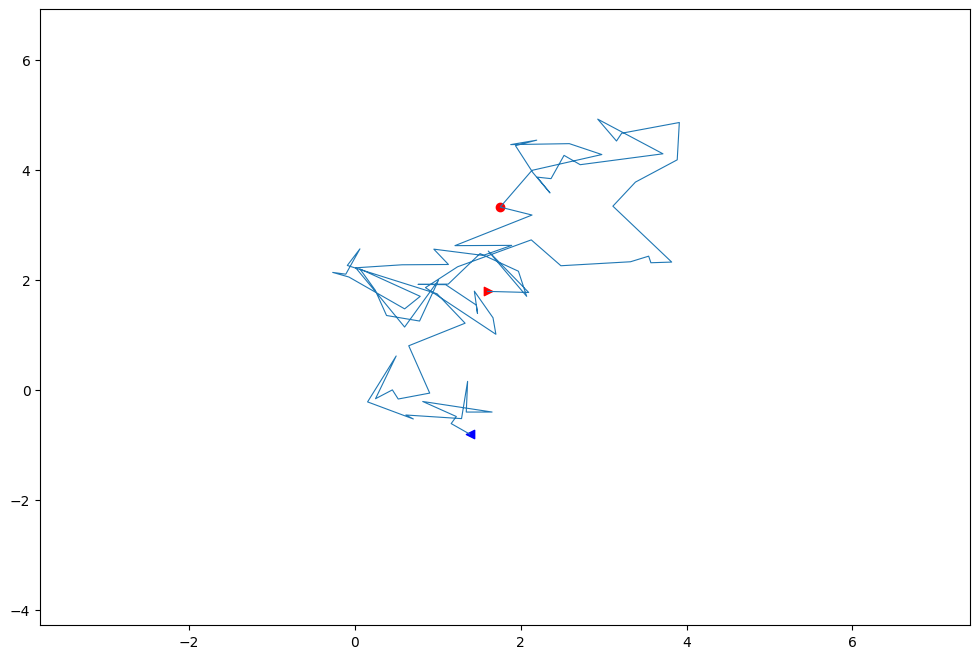

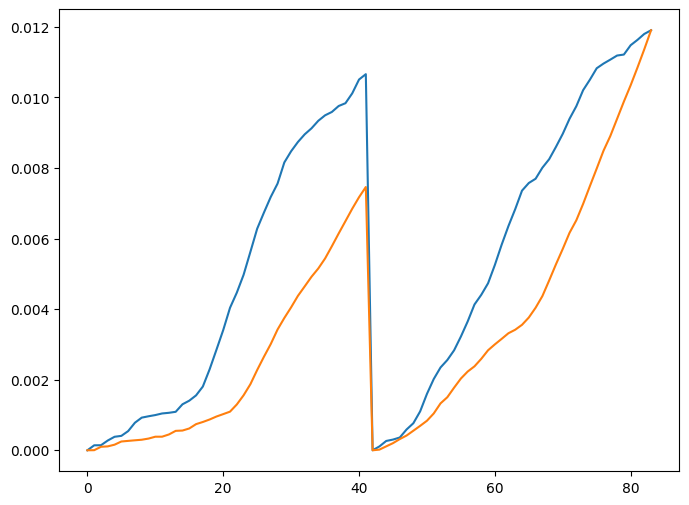

In [80]:
checkpoint = 83
val = []
for WINDOW_WIDTH, c in zip(WINDOW_WIDTHS, COLORS):
    if checkpoint - int(WINDOW_WIDTH/2) >= 0 and checkpoint + int(WINDOW_WIDTH/2) <= len(trajs_model[:, 0, 0]):
        xs = trajs_model[:, 0, 0][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        ys = trajs_model[:, 0, 1][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]

        plt.figure(figsize=(12, 8))
        plt.plot(xs, ys, linewidth=0.8)
        plt.scatter(xs[int(WINDOW_WIDTH/2)], ys[int(WINDOW_WIDTH/2)], c='red')

        plt.xlim([np.min(trajs_model[:, 0, 0]) - 2,
                  np.min(trajs_model[:, 0, 0]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                    np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1])) + 2])
        plt.ylim([np.min(trajs_model[:, 0, 1]) - 2,
                  np.min(trajs_model[:, 0, 1]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                    np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1])) + 2])
        plt.scatter(xs[0], ys[0], marker='>', c='red')
        plt.scatter(xs[-1], ys[-1], marker='<', c='blue')


        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

        xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
        xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

        ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
        ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

        std_xs1 = np.std(xs1)
        std_xs2 = np.std(xs2)
        std_ys1 = np.std(ys1)
        std_ys2 = np.std(ys2)

        surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
        surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
        surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
        surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH


        xs1 = np.cumsum(abs(xs1)) #* surface_xs1
        xs2 = np.cumsum(abs(xs2)) #* surface_xs2
        ys1 = np.cumsum(abs(ys1)) #* surface_ys1
        ys2 = np.cumsum(abs(ys2)) #* surface_ys2


        xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
        xs1 = xs1 / xs_max_val
        xs2 = xs2 / xs_max_val
        xs1 = xs1 / WINDOW_WIDTH
        xs2 = xs2 / WINDOW_WIDTH

        ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
        ys1 = ys1 / ys_max_val
        ys2 = ys2 / ys_max_val
        ys1 = ys1 / WINDOW_WIDTH 
        ys2 = ys2 / WINDOW_WIDTH


        """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
        """

        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #val.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #val.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        print(np.sum(xs1 - xs2), np.sum(ys1 - ys2))
        print(std_xs1, std_xs2, std_ys1, std_ys2)
        #val.append(abs(np.sum(xs1 - xs2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + np.sum(ys1 - ys2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2))))
        #val.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))
        val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) 
                   * abs((max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                         * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2))))

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        #val.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)

        #xs1 = xs1 / np.std(xs1)
        #xs2 = xs2 / np.std(xs2)
        #ys1 = ys1 / np.std(ys1)
        #ys2 = ys2 / np.std(ys2)

        #xs1 = np.cumsum(xs1)
        #xs2 = np.cumsum(xs2)
        #ys1 = np.cumsum(ys1)
        #ys2 = np.cumsum(ys2)
        #ys1 = abs(ys1)
        #ys2 = abs(ys2)

        """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
        """
        """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)

        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)

        print(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
                     + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
        """

        my_xs = np.concatenate((xs1, xs2))
        my_ys = np.concatenate((ys1, ys2))

        plt.figure()
        plt.plot(np.arange(WINDOW_WIDTH), my_xs )
        plt.plot(np.arange(WINDOW_WIDTH), my_ys )
print(val)
print(np.log(val[0] * val[1] * val[2]))